In [1]:
import pandas as pd

from IPython.display import display


from sklearn.preprocessing import  MinMaxScaler


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

from catboost import CatBoostClassifier



import warnings
warnings.filterwarnings("ignore")

In [2]:

# Load the dataset
df = pd.read_csv(r"D:\tesis_u_sabana\data\results\contracts_colombia__analysis.csv", sep="~", encoding='utf-8')

In [3]:
df.head(9)

id_contrato                                     nombre_entidad  \
0  co1.pccntr.3402292                    municipio de san jose de cucuta   
1  co1.pccntr.2494789  sena regional quindio grupo de apoyo administr...   
2  co1.pccntr.2993001                                municipio el retiro   
3  co1.pccntr.3361440               ministerio de educacion nacional men   
4  co1.pccntr.3463351  subred integrada de servicios de salud norte e...   
5  co1.pccntr.4524505               comision nacional del servicio civil   
6  co1.pccntr.2739911                              gobernacion de narino   
7  co1.pccntr.6412677                             alcaldia de villamaria   
8  co1.pccntr.2377923  unidad administrativa especial de gestion de r...   

   nit_entidad_x estado_contrato              departamento_x     ciudad_x  \
0      890501434         cerrado          norte de santander       cucuta   
1      899999034         cerrado                     quindio      armenia   
2      890983674       terminado                   antioquia       retiro   
3      899999001         cerrado  distrito capital de bogota       bogota   
4      900971006       terminado  distrito capital de bogota  no definido   
5      900003409          cedido  distrito capital de bogota  no definido   
6      800103923       terminado                      narino        pasto   
7      890801152         cerrado                      caldas   villamaria   
8      900498879       terminado  distrito capital de bogota       bogota   

         orden                             sector                  rama  \
0  territorial                   servicio publico             ejecutivo   
1     nacional                            trabajo             ejecutivo   
2  territorial                   servicio publico             ejecutivo   
3     nacional                 educacion nacional             ejecutivo   
4  territorial          salud y proteccion social  corporacion autonoma   
5     nacional              no aplicano pertenece  corporacion autonoma   
6  territorial              no aplicano pertenece             ejecutivo   
7  territorial                   servicio publico             ejecutivo   
8     nacional  inclusion social y reconciliacion             ejecutivo   

  entidad_centralizada_x  ...    capital d_a_capital poblacion_m  va_2022_a1  \
0           centralizada  ...     cucuta    0.000000      770173  526.333254   
1        descentralizada  ...    armenia    0.000000      302613  331.158187   
2           centralizada  ...   medellin   25.025513       24466  165.286471   
3           centralizada  ...     bogota    0.000000     7732161  500.226034   
4        descentralizada  ...     bogota    0.000000     7732161  500.226034   
5           centralizada  ...     bogota    0.000000     7732161  500.226034   
6           centralizada  ...      pasto    0.000000      402073  299.310877   
7           centralizada  ...  manizales   17.802922       66914  160.281623   
8           centralizada  ...     bogota    0.000000     7732161  500.226034   

     va_2022_a2     va_2022_a3        va_2022 va_%_d_2022      %_nbi  \
0   1933.655458    9264.157243   11724.145954   53.747921  13.750122   
1    795.167698    4685.251384    5811.577269   51.169375   5.376065   
2     52.463445     627.259692     845.009607    0.441314   4.609102   
3  40817.177921  275000.089160  316317.493116  100.000000   3.471188   
4  40817.177921  275000.089160  316317.493116  100.000000   3.471188   
5  40817.177921  275000.089160  316317.493116  100.000000   3.471188   
6    858.634281    6433.293781    7591.238939   37.492337   8.244979   
7     50.759991     607.958657     819.000271    3.743355   6.861228   
8  40817.177921  275000.089160  316317.493116  100.000000   3.471188   

    tipo_de_modificacion  
0            sin_cambios  
1            sin_cambios  
2  modificacion_riesgosa  
3  modificacion_riesgosa  
4  modificacion_riesgosa  
5            sin_cambios  
6            sin

In [4]:
#preprocess the data
# Drop unnecessary columns
df.drop(columns=['id_contrato', 'documento_proveedor','nit_entidad_x','va_2022_a1', 'fecha_de_inicio_del_contrato',
                  'fecha_de_fin_del_contrato','va_2022_a2', 'va_2022_a3', 'va_2022', 'va_%_d_2022','valor_facturado',
                  'valor_pendiente_de_pago','valor_de_pago_adelantado','valor_pendiente_de_ejecucion','codigo_proveedor',
                  'id_del_proceso', 'id_del_portafolio','dominant_topic_y','valor_del_contrato_y','codigo','departamento_y', 'latitud',
                  'longitud', 'codigo_capital', 'capital','estado_contrato'], inplace=True)


#drop index
df.drop(df.index[0], inplace=True)

#Scale the data that hasnt been scaled yet
scaler = MinMaxScaler()
df[['poblacion_m']] = scaler.fit_transform(df[['poblacion_m']])
df[['%_nbi']] = scaler.fit_transform(df[['%_nbi']])
df[['d_a_capital']] = scaler.fit_transform(df[['d_a_capital']])

In [5]:
#get X and y
y = df['tipo_de_modificacion']
X = df.drop(columns=['tipo_de_modificacion'])

In [6]:
def mccv_evaluation(learner, X, y, repeats=10, train_size=0.7, pipeline_name=None):
    print("Performing Monte Carlo Cross Validation for Evaluation")
    print(f"Repeats: {repeats}")
    label_order = np.unique(y)
    conf_matrix_sum = None
    f_score_sum = 0.000001

    #for catboost
    # Detectar columnas categóricas automáticamente
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    X = X.copy()
    X[categorical_features] = X[categorical_features].fillna("missing").astype('category')
    X["dominant_topic_x"] = X["dominant_topic_x"].astype("category")

    categorical_features.append("dominant_topic_x")

    print(f"Categorical features: {categorical_features}")


    # Prepare for ROC aggregation
    all_y_true = []
    all_y_prob = []

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'MCCV Evaluation - {pipeline_name}')

    color_map = {
        "sin_cambios": "green",
        "modificacion_riesgosa": "red",
        "modificacion_general": "gold"
    }

    for i in range(repeats):
        print(f"Iteration {i + 1} of {repeats}")
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=train_size, stratify=y, random_state=i
        )
        learner.fit(X_train, y_train,cat_features=categorical_features)
        y_pred = learner.predict(X_val)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred, labels=label_order)
        conf_matrix_sum = cm if conf_matrix_sum is None else conf_matrix_sum + cm

        f_score_sum += f1_score(y_val, y_pred, average="weighted", labels=label_order)

        try:
            y_prob = learner.predict_proba(X_val)
            all_y_true.extend(y_val)
            all_y_prob.extend(y_prob)
        except AttributeError:
            print("Warning: predict_proba not available.")

    # Plot confusion matrix
    avg_conf_matrix = conf_matrix_sum / repeats
    avg_confusion_df = pd.DataFrame(avg_conf_matrix, index=label_order, columns=label_order)
    sns.heatmap(avg_confusion_df, annot=True, cmap="Blues", fmt=".2f", cbar=True,
                xticklabels=label_order, yticklabels=label_order,
                linewidths=0.5, linecolor="grey", ax=ax1,
                vmin=0, vmax=(len(y_val)/3)*1.1,
                cbar_kws={"shrink": .8})

    ax1.set_xlabel("Predicted Label")
    ax1.set_ylabel("True Label")
    ax1.set_title("Average Confusion Matrix")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    print(f"Average F1 Score: {f_score_sum/repeats:.4f}")

    # Plot ROC Curve using aggregated predictions
    try:
        all_y_true_bin = label_binarize(all_y_true, classes=label_order)
        all_y_prob = np.array(all_y_prob)

        for j, class_label in enumerate(label_order):
            RocCurveDisplay.from_predictions(
                all_y_true_bin[:, j],
                all_y_prob[:, j],
                ax=ax2,
                name=f"Class {class_label}",
                color=color_map.get(class_label, "gray")
            )
    except Exception as e:
        print(f"Could not plot ROC: {e}")

    ax2.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Multi-class ROC Curve (One-vs-Rest)')
    ax2.legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return avg_confusion_df


Performing Monte Carlo Cross Validation for Evaluation
Repeats: 10
Categorical features: ['nombre_entidad', 'departamento_x', 'ciudad_x', 'orden', 'sector', 'rama', 'entidad_centralizada_x', 'codigo_de_categoria_principal', 'tipo_de_contrato_x', 'modalidad_de_contratacion_x', 'justificacion_modalidad_de_contratacion', 'tipodocproveedor', 'proveedor_adjudicado', 'es_grupo', 'es_pyme', 'liquidacion', 'obligacion_ambiental', 'obligaciones_postconsumo', 'origen_de_los_recursos', 'espostconflicto', 'urlproceso_x', 'genero_representante_legal', 'nombre_del_banco', 'tipo_de_cuenta', 'modalidad_de_contratacion_y', 'nombre_de_la_unidad_de_contratación', 'codigo_principal_de_categoria', 'tipo_de_contrato_y', 'estado_resumen', 'ciudad_de_la_unidad_de_contratación', 'ciudad_proveedor', 'ciudad_y', 'dominant_topic_x']
Iteration 1 of 10
Learning rate set to 0.28715
0:	learn: 0.9813462	total: 126ms	remaining: 2m 5s
1:	learn: 0.9175874	total: 244ms	remaining: 2m 1s
2:	learn: 0.8763303	total: 357ms	rem

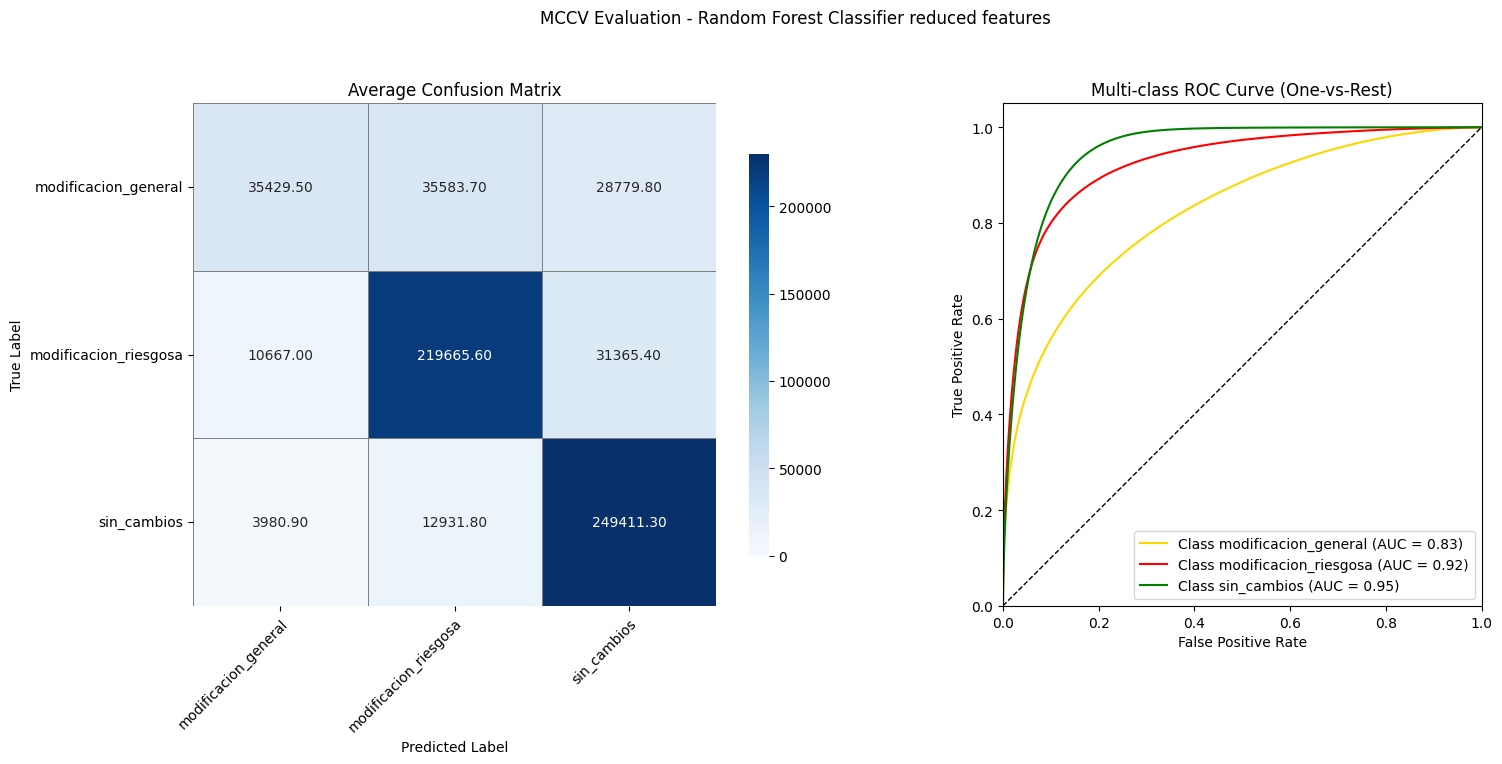

modificacion_general  modificacion_riesgosa  \
modificacion_general                35429.5                35583.7   
modificacion_riesgosa               10667.0               219665.6   
sin_cambios                          3980.9                12931.8   

                       sin_cambios  
modificacion_general       28779.8  
modificacion_riesgosa      31365.4  
sin_cambios               249411.3

In [ ]:
model = CatBoostClassifier(
    random_seed=7,
    task_type="GPU"
)

avg_conf_matrix = mccv_evaluation(model, X, y, repeats=10,train_size=0.7, pipeline_name="Catboost Classifier")

display(avg_conf_matrix)
# Save the average confusion matrix to a CSV file   
avg_conf_matrix.to_csv('average_confusion_matrix.csv', index=True, sep=',')


In [8]:
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
X = X.copy()
X[categorical_features] = X[categorical_features].fillna("missing").astype('category')
X["dominant_topic_x"] = X["dominant_topic_x"].astype("category")

categorical_features.append("dominant_topic_x")

In [9]:
#train the best model with all the data
model.fit(X, y,cat_features=categorical_features)
print("Training done")

import joblib
# Save the model to a file
joblib.dump(model, 'model_4_catboost.pkl')
print("Model saved!")


Learning rate set to 0.308822
0:	learn: 0.9740914	total: 117ms	remaining: 1m 57s
1:	learn: 0.9067752	total: 204ms	remaining: 1m 41s
2:	learn: 0.8653966	total: 294ms	remaining: 1m 37s
3:	learn: 0.8399856	total: 364ms	remaining: 1m 30s
4:	learn: 0.8190671	total: 434ms	remaining: 1m 26s
5:	learn: 0.8058144	total: 505ms	remaining: 1m 23s
6:	learn: 0.7947736	total: 568ms	remaining: 1m 20s
7:	learn: 0.7807103	total: 634ms	remaining: 1m 18s
8:	learn: 0.7723881	total: 704ms	remaining: 1m 17s
9:	learn: 0.7666353	total: 769ms	remaining: 1m 16s
10:	learn: 0.7608891	total: 840ms	remaining: 1m 15s
11:	learn: 0.7528860	total: 913ms	remaining: 1m 15s
12:	learn: 0.7468389	total: 978ms	remaining: 1m 14s
13:	learn: 0.7435753	total: 1.05s	remaining: 1m 14s
14:	learn: 0.7393119	total: 1.12s	remaining: 1m 13s
15:	learn: 0.7321490	total: 1.18s	remaining: 1m 12s
16:	learn: 0.7293546	total: 1.26s	remaining: 1m 12s
17:	learn: 0.7258497	total: 1.34s	remaining: 1m 13s
18:	learn: 0.7181582	total: 1.41s	remaining:

In [22]:
from catboost import CatBoostClassifier, Pool


pool = Pool(X, label=y, cat_features=categorical_features)

# ---- 5. Compute different feature importance types ----

# 5.1 PredictionValuesChange (default)
importance_pred_change = model.get_feature_importance()

# 5.2 LossFunctionChange (needs Pool)
importance_loss_change = model.get_feature_importance(data=pool, type='LossFunctionChange')


# ---- 6. Create the DataFrame ----

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'PredictionValuesChange': importance_pred_change,
    'LossFunctionChange': importance_loss_change
})

# Sort by the most important feature (optional)
importance_df = importance_df.sort_values(by='PredictionValuesChange', ascending=False)

print(importance_df)

# ---- 7. (Optional) Save the feature importance to CSV ----

importance_df.to_csv('feature_importances.csv', index=False)
print("Feature importances saved to feature_importances.csv")


                                    Feature  PredictionValuesChange  \
30                              precio_base               26.326879   
20                     valor_del_contrato_x               22.907038   
7                        duracion_en_dias_x               10.184978   
0                            nombre_entidad                9.225287   
40                    duracion_proceso_dias                9.180520   
32      nombre_de_la_unidad_de_contratación                4.130793   
24                             urlproceso_x                2.371784   
4                                    sector                2.043080   
21                             valor_pagado                1.494160   
8             codigo_de_categoria_principal                1.164302   
22                                saldo_cdp                1.163684   
2                                  ciudad_x                1.039855   
1                            departamento_x                0.902325   
41    